## Gradient Boosting Of Gala apple by predicting the next time step using a sequence of past 5 observations

In [1]:
import pandas as pd
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### ***Prepare Dataset of Gala Apples***

In [2]:
df_gala = pd.read_csv("../../../DataSet/Gala/gala.csv")
df_gala.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    169 non-null    object
 1   Gala    169 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [3]:
df_gala["Date"] = pd.to_datetime(df_gala["Date"], format="%d/%m/%Y")
df_gala.sort_values(by="Date", inplace=True)
df_gala

,Date,Gala
0,2015-01-04,2752
1,2015-01-11,3322
2,2015-01-18,2257
3,2015-01-25,2061
4,2015-02-01,2905
...,...,...
164,2018-02-25,11798
165,2018-03-04,10102
166,2018-03-11,12281
167,2018-03-18,7738


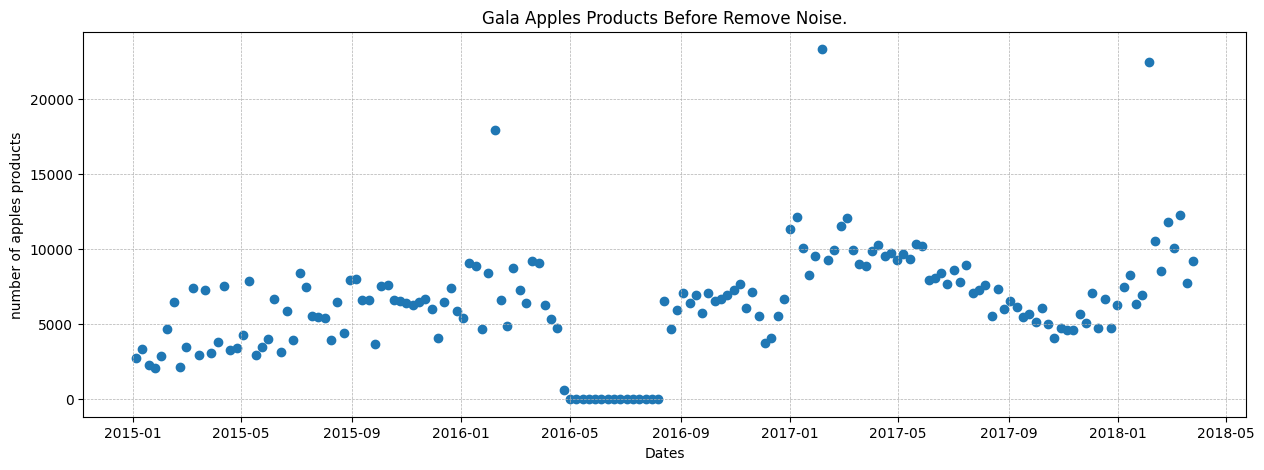

In [4]:
plt.figure(figsize=(15,5))
plt.title("Gala Apples Products Before Remove Noise.")
plt.scatter(df_gala["Date"], df_gala["Gala"])
plt.xlabel("Dates")
plt.ylabel("number of apples products")
plt.grid(linestyle='--', linewidth='0.5')
plt.show()

Remove Noise

In [5]:
df_gala = df_gala[df_gala["Gala"] <= 10000]
df_gala = df_gala[df_gala["Gala"] > 1000]
df_gala

,Date,Gala
0,2015-01-04,2752
1,2015-01-11,3322
2,2015-01-18,2257
3,2015-01-25,2061
4,2015-02-01,2905
...,...,...
159,2018-01-21,6343
160,2018-01-28,6962
163,2018-02-18,8576
167,2018-03-18,7738


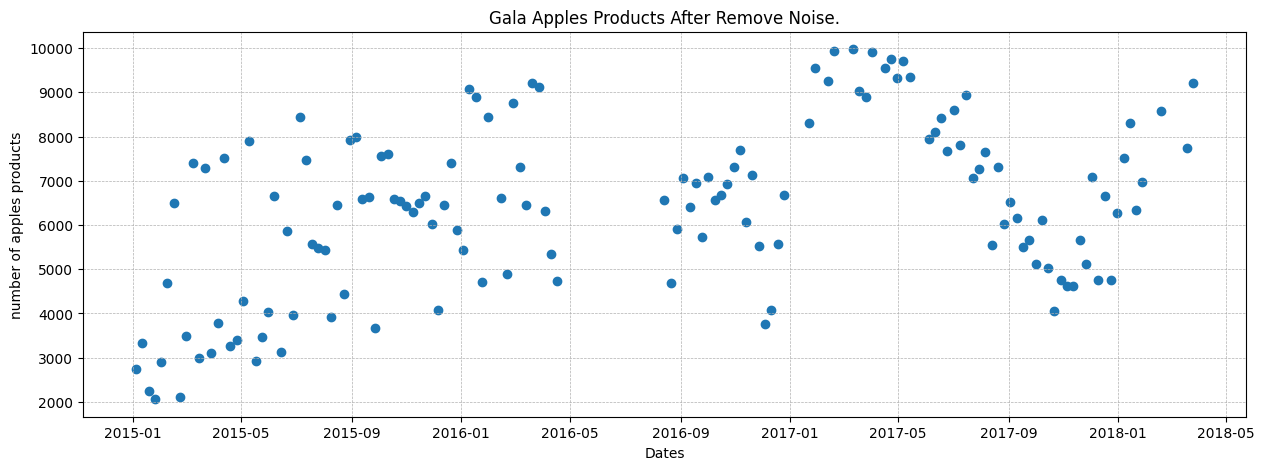

In [6]:
plt.figure(figsize=(15,5))
plt.title("Gala Apples Products After Remove Noise.")
plt.scatter(df_gala["Date"], df_gala["Gala"])
plt.xlabel("Dates")
plt.ylabel("number of apples products")
plt.grid(linestyle='--', linewidth='0.5')
plt.show()

In [7]:
def writeEvaluate(model, mae:np.float64, mse:np.float64, r2:np.float64, mape:np.float64, filename):
    df = pd.read_csv(filename)
    row_index = df.index.get_loc(df.loc[df['Model'] == model].index[0])
    df.at[row_index,'Mae'] = mae
    df.at[row_index,'Mse'] = mse
    df.at[row_index,'R2'] = r2
    df.at[row_index,'Mape'] = mape

    df.to_csv(filename,encoding='utf-8', sep=',', index=False)

In [8]:
def findBestRandomState(r,t, x, y):
    random = 0
    a = 1000000

    model = RegressorChain(GradientBoostingRegressor())
    for _ in range(r,t):
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=_)
        model.fit(x_train[:,1:], y_train[:,1:])

        y_predict = model.predict(x_test[:,1:])
        if (buff := mean_absolute_error(y_test[:, 1:], y_predict)) < a:
            a = buff
            random = _
        
        if _ == '50000':
            print(_)
            
    print(a, random)

Function Create X Sequence to Predict 1

In [9]:
def createSequenceToOneDataSet(r, data:pd.DataFrame):  # Create Sequence DataSet
    df = data.copy()
    i = 1
    
    while i < r:
        df[f'x{i}'] = df['Gala'].shift(-i)
        i += 1

    if i == r:
        df['y'] = df['Gala'].shift(-i)

    df = df.dropna(axis=0)
    return df

Predict the next time step using a sequence of past 5 observations

In [10]:
df = createSequenceToOneDataSet(5, df_gala)
df

,Date,Gala,x1,x2,x3,x4,y
0,2015-01-04,2752,3322.0,2257.0,2061.0,2905.0,4699.0
1,2015-01-11,3322,2257.0,2061.0,2905.0,4699.0,6493.0
2,2015-01-18,2257,2061.0,2905.0,4699.0,6493.0,2122.0
3,2015-01-25,2061,2905.0,4699.0,6493.0,2122.0,3492.0
4,2015-02-01,2905,4699.0,6493.0,2122.0,3492.0,7404.0
...,...,...,...,...,...,...,...
154,2017-12-17,6656,4751.0,6263.0,7511.0,8299.0,6343.0
155,2017-12-24,4751,6263.0,7511.0,8299.0,6343.0,6962.0
156,2017-12-31,6263,7511.0,8299.0,6343.0,6962.0,8576.0
157,2018-01-07,7511,8299.0,6343.0,6962.0,8576.0,7738.0


Find Best Random State

In [11]:
# findBestRandomState(99999,200000,x, y)
# seed 304 MAE: 903.0120301390671  1-1000
# seed 2870 MAE: 738.9116015155478 999-10000
# seed 52650 MAE: 779.9526513445359 9999-100000

In [12]:
x = np.array(df.drop(columns='y'))
y = np.array(df.drop(columns=['Gala','x1','x2','x3','x4']))

# scaler = StandardScaler()
# scaler.fit(x)
# x = scaler.transform(x)
# scaler.fit(y.reshape(-1,1))
# y = scaler.transform(y.reshape(-1,1))


x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=2870)

x_train = np.array(sorted(x_train, key=lambda x: x[0]))
x_test = np.array(sorted(x_test, key=lambda x: x[0]))
y_train = np.array(sorted(y_train, key=lambda x: x[0]))
y_test = np.array(sorted(y_test, key=lambda x: x[0]))


### ***Train Model Of Gala Apples***

In [13]:
ml = RegressorChain(GradientBoostingRegressor(learning_rate=0.3, min_samples_leaf=1, alpha=0.35, n_estimators=130, random_state=18))
ml.fit(x_train[:, 1:], y_train[:, 1:])

RegressorChain(base_estimator=GradientBoostingRegressor(alpha=0.35,
                                                        learning_rate=0.3,
                                                        n_estimators=130,
                                                        random_state=18))

### ***Predict from test_dataset Of Gala Apples***

In [14]:
y_predict = ml.predict(x_test[:, 1:])

mae = mean_absolute_error(y_test[:, 1:], y_predict)
mse = mean_squared_error(y_test[:, 1:], y_predict)
r2 = r2_score(y_test[:, 1:], y_predict)
mape = mean_absolute_percentage_error(y_test[:, 1:], y_predict)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Square Error: {mse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}")

writeEvaluate("GradientBoosting",mae,mse,r2,mape,"evaluate.csv")

Mean Absolute Error: 755.4514570457474
Mean Square Error: 879296.9830683654
R2 score: 0.7202818467453124
Mean Absolute Percentage Error: 0.10760516294200988


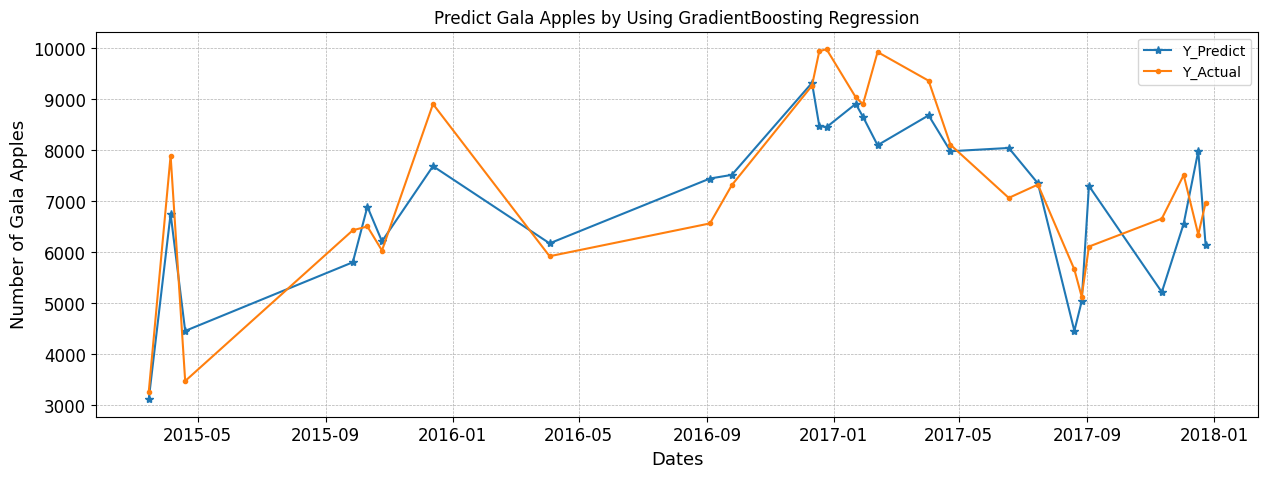

In [15]:
plt.figure(figsize=(15, 5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(x_test[:, :1], y_predict, label="Y_Predict", marker='*')
plt.plot(x_test[:,:1], y_test[:, 1:], label="Y_Actual", marker='.')
plt.xlabel("Dates", fontsize=13)
plt.ylabel("Number of Gala Apples", fontsize=13)
plt.title("Predict Gala Apples by Using GradientBoosting Regression")
plt.grid(linestyle='--', linewidth='0.5')
plt.legend()
plt.show()

---